In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm
from glob import glob
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
import xml.etree.ElementTree as xet
from keras.models import load_model, Sequential
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

In [3]:
import os

path = os.getcwd()+"/archive/annotations"

In [4]:
labels=[]
for filename in os.listdir(path):
    data = xet.parse(path+"/"+filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels.append((filename,xmin,xmax,ymin,ymax))

In [5]:
df = pd.DataFrame(labels)
df.columns=["filepath","xmin","xmax","ymin","ymax"]
df

,filepath,xmin,xmax,ymin,ymax
0,Cars213.xml,150,233,160,194
1,Cars207.xml,254,372,229,264
2,Cars398.xml,72,196,139,222
3,Cars367.xml,224,382,161,222
4,Cars401.xml,158,238,223,240
...,...,...,...,...,...
428,Cars418.xml,99,303,70,155
429,Cars395.xml,241,288,182,205
430,Cars381.xml,65,147,131,155
431,Cars222.xml,178,235,158,170


In [6]:
image_path=[]
def load_images(directory):
    images = []

    for filepath in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory,filepath)
        #print(img_path)
        image_path.append(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        ### removes salt and pepper noise
        img = cv2.medianBlur(img,5)
        images.append(img)
    
    images = np.array(images).reshape(len(images),224,224,3)
    return images

In [7]:
images = load_images(os.getcwd()+"/archive/images")

  0%|          | 0/433 [00:00<?, ?it/s]

In [8]:
bbox_coords = df.iloc[:,1:].values
labels = []

for ind in range(len(image_path)):
    #print(ind)
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    xmin,xmax,ymin,ymax = bbox_coords[ind]
    nxmin, nxmax = int(xmin/(w/255.)), int(xmax/(w/255.))
    nymin, nymax = int(ymin/(h/255.)), int(ymax/(h/255.))
    labels.append((nxmin,nxmax,nymin,nymax))

In [9]:
labels = np.array(labels)
labels

array([[ 95, 148,  85, 103],
       [161, 237, 194, 224],
       [ 45, 124, 123, 196],
       ...,
       [ 28,  63,  95, 112],
       [113, 149, 228, 246],
       [142, 159, 117, 131]])

In [10]:
X = np.array(images,dtype=np.float32)
y = np.array(labels,dtype=np.float32)

In [11]:
X = X / 255.
y = y / 255.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [13]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

2022-11-13 22:49:09.467597: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 22:49:09.469534: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
__________________________________

In [14]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [16]:
r = model.fit(X_train,
              y_train,
              epochs=20,
              batch_size=32,
              validation_data=(X_val,y_val),
              verbose=1)

Train on 311 samples, validate on 35 samples
Epoch 1/20
311/311 [==============================] - 103s 331ms/step - loss: 0.0825 - accuracy: 0.4341 - val_loss: 0.1011 - val_accuracy: 0.4571
Epoch 2/20
311/311 [==============================] - 102s 328ms/step - loss: 0.0454 - accuracy: 0.5563 - val_loss: 0.0776 - val_accuracy: 0.3714
Epoch 3/20
311/311 [==============================] - 101s 325ms/step - loss: 0.0350 - accuracy: 0.5595 - val_loss: 0.0983 - val_accuracy: 0.5143
Epoch 4/20
311/311 [==============================] - 102s 327ms/step - loss: 0.0262 - accuracy: 0.7170 - val_loss: 0.0778 - val_accuracy: 0.6000
Epoch 5/20
311/311 [==============================] - 104s 334ms/step - loss: 0.0204 - accuracy: 0.7395 - val_loss: 0.0889 - val_accuracy: 0.5143
Epoch 6/20
311/311 [==============================] - 101s 325ms/step - loss: 0.0168 - accuracy: 0.8328 - val_loss: 0.0951 - val_accuracy: 0.5714
Epoch 7/20
311/311 [==============================] - 1615s 5s/step - loss: 0.0

In [17]:
model.save('license_plate_detector.h5')

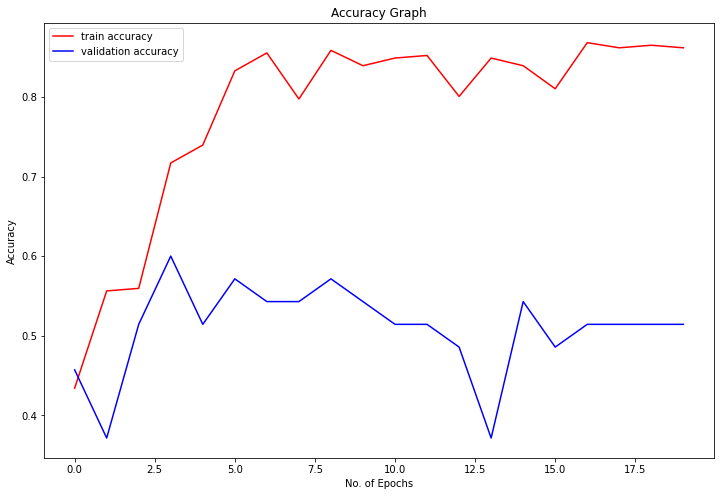

In [18]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();